In [1]:
import numpy as np
import rasterio
from pathlib import Path
from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
project_root = Path('.').resolve().parent
locations = ['ludhiana', 'ujjain', 'thanjavur']
patch_size = 64
all_patches = []
all_labels = []

In [3]:
# THE PATCH EXTRACTION FUNCTION ---
def extract_patches(image, label_mask, patch_size=64, stride=32):
    # (Same function as before)
    image_patches, patch_labels = [], []
    h, w, _ = image.shape
    for y in range(0, h - patch_size, stride):
        for x in range(0, w - patch_size, stride):
            image_patch = image[y:y+patch_size, x:x+patch_size]
            label_patch = label_mask[y:y+patch_size, x:x+patch_size]
            label, count = stats.mode(label_patch, axis=None, keepdims=False)
            if count / (patch_size * patch_size) > 0.5:
                image_patches.append(image_patch)
                patch_labels.append(label)
    return image_patches, patch_labels

In [5]:
# LOOP THROUGH LOCATIONS TO BUILD MASTER DATASET ---
for loc in locations:
    print(f"--- Processing {loc.title()} ---")
    try:
        # Define paths to your processed .tif files
        processed_path = project_root / 'data' / 'processed' / loc
        ndvi_path = list(processed_path.glob('*NDVI.tif'))[0]
        savi_path = list(processed_path.glob('*SAVI.tif'))[0]
        ndwi_path = list(processed_path.glob('*NDWI.tif'))[0]

        # Load the three selected index maps
        with rasterio.open(ndvi_path) as src:
            ndvi = src.read(1)
        with rasterio.open(savi_path) as src:
            savi = src.read(1)
        with rasterio.open(ndwi_path) as src:
            ndwi = src.read(1)
        # Create the label mask from NDVI using our dynamic method
        labels = np.zeros_like(ndvi, dtype=np.uint8)
        vegetation_ndvi = ndvi[ndvi > 0.1]
        if vegetation_ndvi.size > 0:
            moderate_thresh = np.nanquantile(vegetation_ndvi, 0.33)
            healthy_thresh = np.nanquantile(vegetation_ndvi, 0.66)
            labels[(ndvi >= moderate_thresh) & (ndvi < healthy_thresh)] = 1
            labels[ndvi >= healthy_thresh] = 2

        # Normalize the 3 chosen indices to a 0-255 range for the model
        ndvi_norm = np.clip((ndvi + 1) / 2 * 255, 0, 255).astype(np.uint8)
        savi_norm = np.clip((savi + 1) / 2 * 255, 0, 255).astype(np.uint8)
        ndwi_norm = np.clip((ndwi + 1) / 2 * 255, 0, 255).astype(np.uint8)
        
        # Stack the chosen indices to form our 3-channel input image
        stacked_indices = np.stack([ndvi_norm, savi_norm, ndwi_norm], axis=-1)

        # Extract patches for this location
        patches, patch_lbls = extract_patches(stacked_indices, labels, patch_size=patch_size)
        all_patches.extend(patches)
        all_labels.extend(patch_lbls)
        
        print(f"Extracted {len(patches)} patches from {loc.title()}.")

    except Exception as e:
        print(f"Could not process {loc.title()}. Error: {e}")

--- Processing Ludhiana ---
Extracted 152 patches from Ludhiana.
--- Processing Ujjain ---
Extracted 104 patches from Ujjain.
--- Processing Thanjavur ---
Extracted 173 patches from Thanjavur.


In [6]:
# FINALIZE AND SPLIT THE DATASET ---
X = np.array(all_patches)
y = np.array(all_labels)

print("\n--- Master Dataset Created ---")
print(f"Total patches: {X.shape[0]}")

# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42, # for reproducibility
    stratify=y      # Important for balanced classes
)

print("\n--- Dataset Split Complete! ---")
print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")


--- Master Dataset Created ---
Total patches: 429

--- Dataset Split Complete! ---
Training images shape: (343, 64, 64, 3)
Training labels shape: (343,)
Validation images shape: (86, 64, 64, 3)
Validation labels shape: (86,)


C:\Users\KRish\AppData\Local\Temp\ipykernel_19188\465997911.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Starting Model Training ---
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.7259 - loss: 0.5944 - val_accuracy: 0.9070 - val_loss: 0.3999
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8834 - loss: 0.2937 - val_accuracy: 0.8953 - val_loss: 0.3768
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9125 - loss: 0.2306 - val_accuracy: 0.8721 - val_loss: 0.3634
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9534 - loss: 0.1625 - val_accuracy: 0.9070 - val_loss: 0.3491
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9592 - loss: 0.1300 - val_accuracy: 0.9186 - val_loss: 0.3288
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9650 - loss: 0.1112 - val_accuracy: 0.9186 - val_loss: 0.3340
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9738 - loss: 0.0887 - val_accuracy: 0.9070 - val_loss: 0.3379
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9796 - l

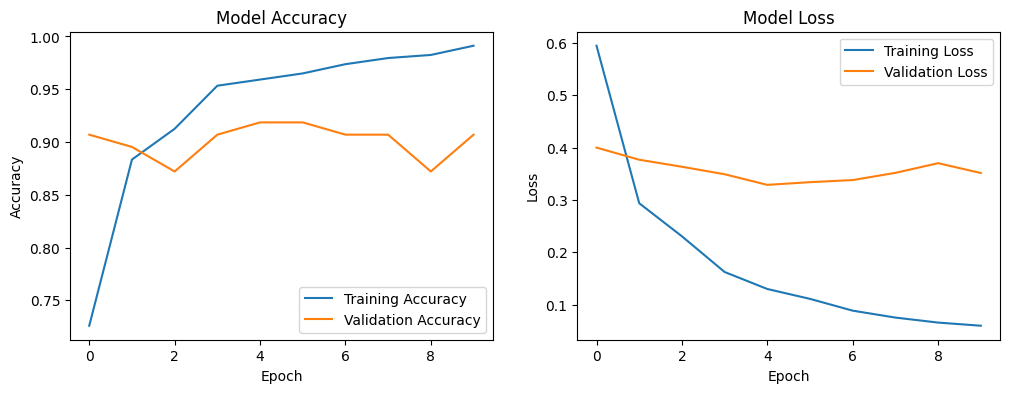

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# --- 1. PREPARE THE DATA ---
# The model needs labels in a "one-hot" format (e.g., 2 becomes [0, 0, 1])
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=3)

# --- 2. BUILD THE MODEL ---
# Define the input shape
input_shape = (64, 64, 3)

# Load the base MobileNetV2 model, pre-trained on ImageNet
base_model = MobileNetV2(input_shape=input_shape,
                         include_top=False, # Don't include the final classifier layer
                         weights='imagenet')

# Freeze the base model's layers
base_model.trainable = False

# Create our custom head
# Start with the output of the base model
x = base_model.output
# Add a pooling layer to flatten the features
x = GlobalAveragePooling2D()(x)
# Add a dense layer for learning
x = Dense(128, activation='relu')(x)
# Add the final prediction layer with 3 units (for 3 classes) and softmax activation
predictions = Dense(3, activation='softmax')(x)

# Combine the base model and our custom head
model = Model(inputs=base_model.input, outputs=predictions)

# --- 3. COMPILE THE MODEL ---
# Configure the model for training
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # For multi-class classification
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# --- 4. TRAIN THE MODEL ---
print("\n--- Starting Model Training ---")
history = model.fit(
    X_train, y_train_cat,
    epochs=10, # A good starting point
    validation_data=(X_val, y_val_cat)
)
print("--- Model Training Complete ---")

# --- 5. VISUALIZE TRAINING RESULTS ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
# Save the model in the recommended native Keras format
model.save('crop_health_model.keras')
print("Model saved successfully as crop_health_model.keras")

Model saved successfully as crop_health_model.keras
